In [ ]:
여러분은 와인 유통사의 데이터 분석가입니다. 
공장에서 와인 성분 데이터(알코올, 도수, 색상 등 13개)가 들어왔는데, 라벨(품종 정보)이 유실되었습니다. 
K-Means를 이용해 와인을 다시 3가지 품종으로 분류하고, 우리가 제대로 분류했는지 실루엣 계수와 엘보우 기법으로 증명해주세요!!!

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [2]:
# 시각화 함수
def visualize_silhouette(cluster_lists, X_features): 
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#### 데이터 로드 및 전처리 (Scaling)

In [9]:
# 1. 데이터 로드
wine = load_wine()
wine_df = pd.DataFrame(data=wine.data,columns=wine.feature_names)

print("데이터 형태(Shape):", wine_df.shape)  
wine_df.describe() 

데이터 형태(Shape): (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [12]:
wine_df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

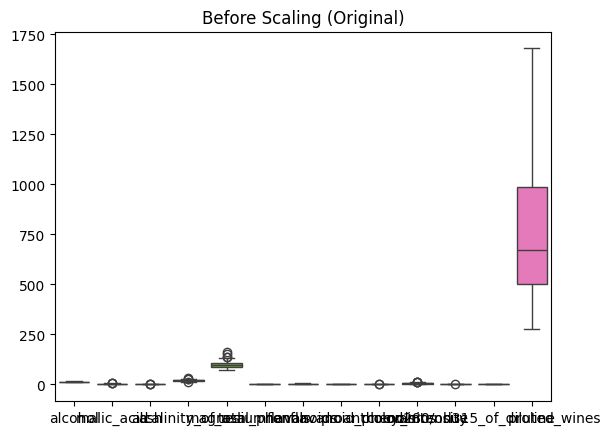

In [24]:
sns.boxplot(data=wine_df)
plt.title('Before Scaling (Original)')
plt.show()

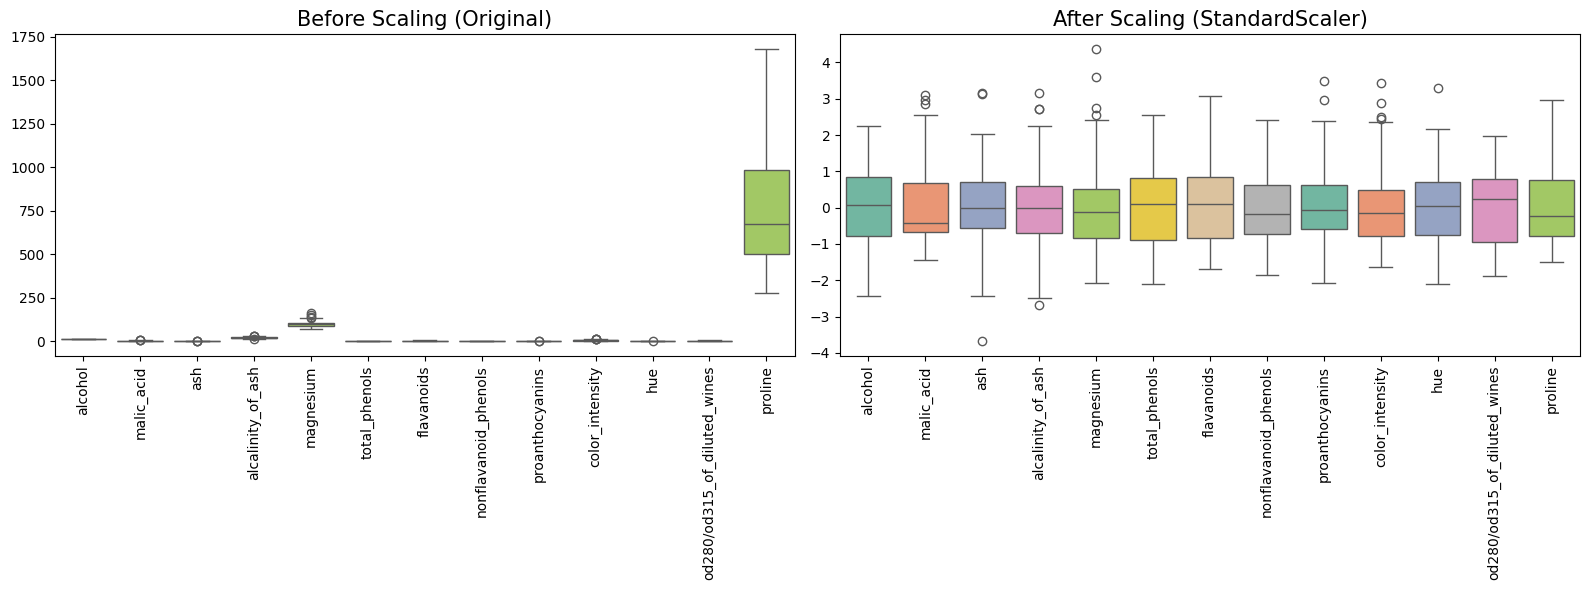

In [ ]:
# 스케일링 전 박스플롯

plt.tight_layout()
plt.show()

In [29]:
# 데이터 전처리 (StandardScaler)
# 와인은 알코올(10단위)과 프롤린(1000단위)의 격차가 큽니다.
# 스케일링을 하지 않으면 거리 기반인 K-Means는 숫자가 큰 프롤린 위주로만 학습하게 됩니다.
scaler = StandardScaler()
wine_scaled = pd.DataFrame(
    scaler.fit_transform(wine_df),
    columns=wine_df.columns
)
wine_scaled

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


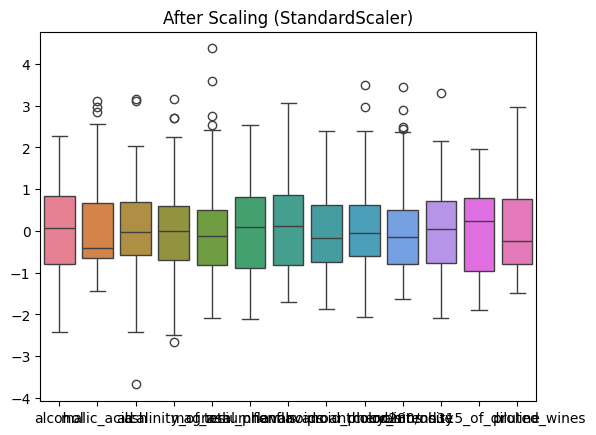

In [30]:
sns.boxplot(data=wine_scaled)
plt.title('After Scaling (StandardScaler)')
plt.show()

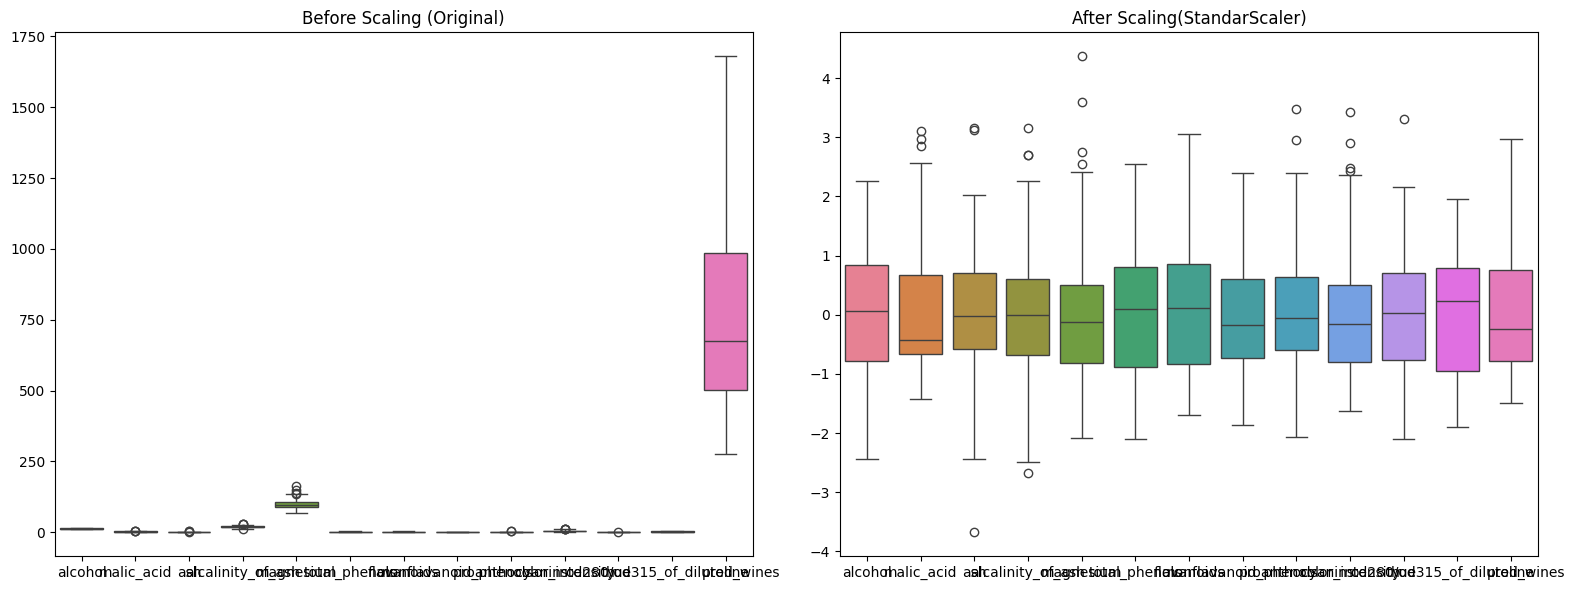

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(data=wine_df)
plt.title('Before Scaling (Original)')

plt.subplot(1,2,2)
sns.boxplot(data=wine_scaled)
plt.title('After Scaling(StandarScaler)')

plt.tight_layout()
plt.show()

#### 최적의 K 찾기

In [34]:
inertia = []
range_k = range(1, 11)
    km = KMeans(n_clusters=n, random_state=42) # random_state 고정
    km.fit(wine_scaled.data)
    print(km.inertia_)
    inertia.append(km.inertia_)

IndentationError: unexpected indent (2238116715.py, line 3)

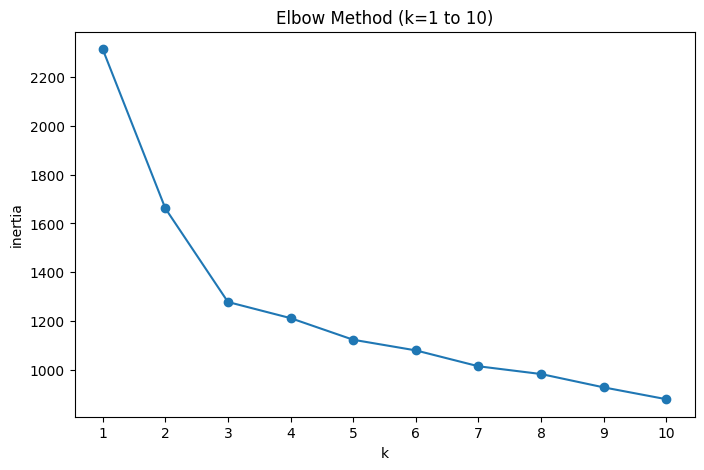

In [39]:
# 최적의 K 찾기 1: 엘보우 기법 (Elbow Method)
inertia = []
range_k = range(1, 11)
for n in range_k:
    km = KMeans(n_clusters=n, random_state=42) # random_state 고정
    km.fit(wine_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_k, inertia, marker='o')
plt.title('Elbow Method (k=1 to 10)')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range_k)
plt.show()

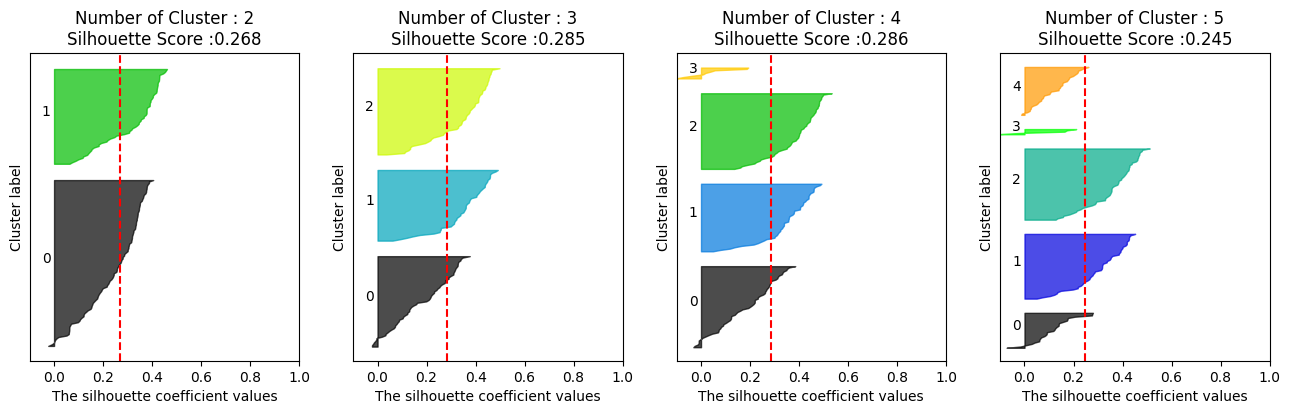

In [40]:
# 최적의 K 찾기 2: 실루엣 분석 (Silhouette Analysis)
# K를 2, 3, 4, 5개로 설정했을 때 각각의 실루엣 계수 비교
visualize_silhouette([2, 3, 4, 5], wine_scaled)

plt.show()
# 해석:


In [ ]:
# 최종 군집화 및 결과 분석 (PCA 시각화)

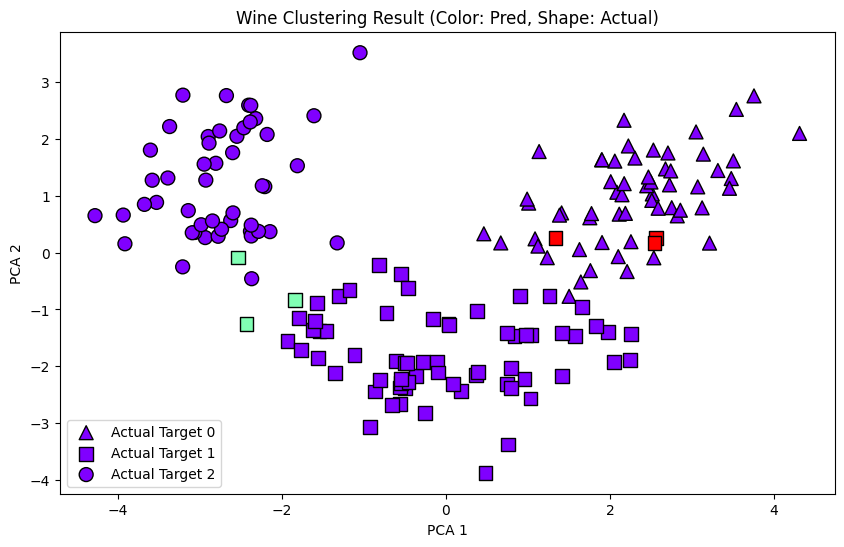


[정답 vs 예측 비교]
cluster   0   1   2
target             
0         0   0  59
1        65   3   3
2         0  48   0


In [44]:
# 위 분석을 통해 최적의 k값 입력해서 확인
best_k = 3

# 1. 최종 모델 학습
kmeans_final = KMeans(n_clusters = best_k, random_state=42)
clusters = kmeans_final.fit_predict(wine_scaled)
clusters

# 2. 결과 데이터프레임에 저장
wine_df['cluster'] = clusters
wine_df['target'] = wine.target
wine_df

# 3. PCA를 이용한 시각화 (13차원 -> 2차원)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(wine_scaled)
pca_transformed

wine_df['pca_x'] = pca_transformed[:,0]
wine_df['pca_y'] = pca_transformed[:,1]
wine_df

plt.figure(figsize=(10, 6))
markers = ['^', 's', 'o']

for i in range(best_k):
    # 각 실제 타겟별로 루프
    target_data = wine_df[wine_df['target'] == i]
    plt.scatter(x=target_data['pca_x'], y=target_data['pca_y'], 
                c=target_data['cluster'], # 색상은 예측값(cluster)
                cmap='rainbow', 
                marker=markers[i],        # 모양은 실제값(target)
                edgecolor='k', s=100, label=f'Actual Target {i}')


plt.title('Wine Clustering Result (Color: Pred, Shape: Actual)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

# 4. 정답(Target)과 예측(Cluster) 교차표 확인
print("\n[정답 vs 예측 비교]")
print(pd.crosstab(wine_df['target'], wine_df['cluster']))